In [1]:
!pip install datasets
!pip install -q transformers sentencepiece

# Load Dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("iamtarun/python_code_instructions_18k_alpaca")

/Users/sh69/miniconda3/envs/CodeSummarization/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate Data Example 

In [3]:
GENERATE_NUM = 10

for indx, data in enumerate(dataset["train"]):
    if indx == GENERATE_NUM:
        break
    with open("./Example_code/Train_"+str(indx),"w") as f:
        f.write(data["instruction"])
        f.write("\n===========================================\n")
        f.write(data["output"])

In [4]:
!pip install nltk rouge

# Model

In [5]:
import tokenize
import io

def pythonTokenizer(line):
    result= []
    line = io.StringIO(line) 
    
    for toktype, tok, start, end, line in tokenize.generate_tokens(line.readline):
        if (not toktype == tokenize.COMMENT):
            if toktype == tokenize.STRING:
                result.append("CODE_STRING")
            elif toktype == tokenize.NUMBER:
                result.append("CODE_INTEGER")
            elif (not tok=="\n") and (not tok=="    "):
                result.append(str(tok))
    return ' '.join(result)

In [6]:
from transformers import AutoTokenizer, AutoModelWithLMHead, SummarizationPipeline
pipeline = SummarizationPipeline(
    model=AutoModelWithLMHead.from_pretrained("SEBIS/code_trans_t5_base_source_code_summarization_python"),
    tokenizer=AutoTokenizer.from_pretrained("SEBIS/code_trans_t5_base_source_code_summarization_python", skip_special_tokens=True),
    device="mps"
)

/Users/sh69/miniconda3/envs/CodeSummarization/lib/python3.10/site-packages/transformers/models/auto/modeling_auto.py:1564: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


# Evaluation

In [14]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

GENERATE_NUM = 1000
score_list = []
for indx, data in enumerate(dataset["train"]):
    if indx == GENERATE_NUM:
        break
    tokenized_code = pythonTokenizer(data["instruction"])
    reference_summary = data["instruction"]
    candidate_summary = pipeline([tokenized_code])[0]["summary_text"]
    # print("++++++++++++++++++++++++++++++++=")
    # print(reference_summary)
    # print(candidate_summary)

    # # BLEU Score
    # bleu_score = sentence_bleu([reference_summary.split()], candidate_summary.split())
    # print(f"BLEU Score: {bleu_score:.4f}")

    # Rouge Score
    rouge = Rouge()
    scores = rouge.get_scores(candidate_summary, reference_summary)
    score_list.append(scores[0]['rouge-1']['f'])
    # print(f"ROUGE Score: {scores[0]['rouge-1']['f']:.4f}")


Your max_length is set to 20, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
/Users/sh69/miniconda3/envs/CodeSummarization/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Your max_length is set to 20, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 20, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing 

In [8]:
print(sum(score_list)/len(score_list))

0.1841817833621649


In [16]:
!pip3 install matplotlib
!pip3 install seaborn

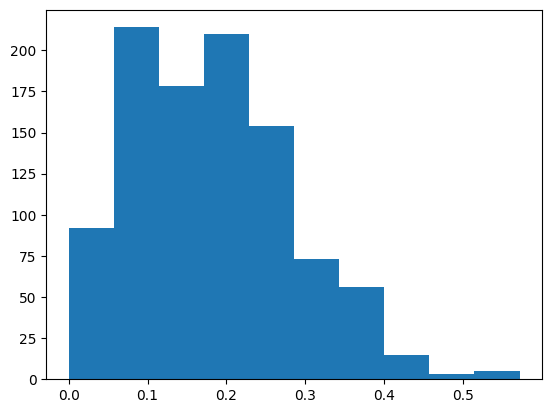

In [17]:
import matplotlib.pyplot as plt
plt.hist(score_list)
plt.show()

<Axes: ylabel='Count'>

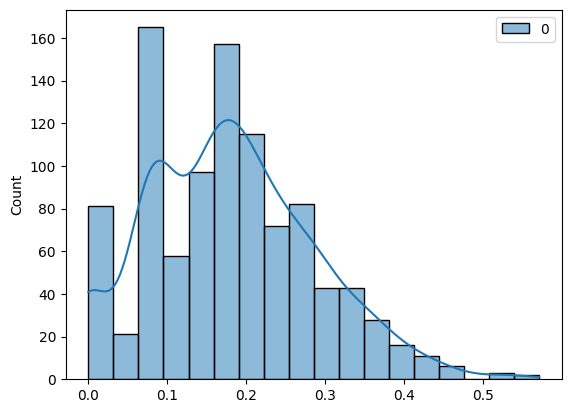

In [22]:
import seaborn as sns
import pandas as pd
new_score_list =  pd.DataFrame(score_list)
sns.histplot(data=new_score_list, kde=True)